## Graph-Based Data Analysis

When it comes to analysing relationships between features - it is fairly typical to use statistical measures as well as visualisations such as histograms, scatter-plots and perhaps even heat-maps. These conventional displays of information between various variables do serve their purpose fairly well - yet there is also another method of conveying the interactions within and between features that proves to be extremely useful for the data - analyst. 

It further warrants a shift in thought for how data should be stored and related to in the first place - moving away from a tabular space to one that is more 'Graphical' in nature (that is to say - using Networks). This project aims to show how displaying information in actual Network based visualisations (henceforth termed Graphs) can prove to be wonderful in gaining insights on data and, while not necessarily being the sole visualisation to be used, is certainly an underrated one.  

*11/1/2025 - 18/1/2025*

In [1]:
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib as mpl
from igraph import Graph, plot # needa have pycairo as well
from collections import Counter
from pyvis.network import Network
from itertools import combinations
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder

In [2]:
file_path = r"dataset.csv"
# Dataset Source: https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset
df = pd.read_csv(file_path)

In [3]:
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [4]:
df = df.drop(df.columns[0],axis=1) 

In [5]:
df.info() # fortunately, there doesn't appear to be too many NA rows of data in the df; can be easily dropped

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          114000 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        114000 non-null  int64  
 5   duration_ms       114000 non-null  int64  
 6   explicit          114000 non-null  bool   
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64  
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  valence           11

In [6]:
df=df.dropna()

In [7]:
df["duration"] = pd.to_datetime(df["duration_ms"],unit='ms').dt.time 
# a separate 'duration' column is created to view the duration in a more human readable format

In [8]:
max_time = 10*60*1000 # max number of milliseconds calculated from 10 minutes (really shld nt have to bother with songs longer than thats) 
df[df["duration_ms"]>max_time].reset_index(drop='index')

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,duration
0,4TbIOAb7FfbhHi2glq0EwA,Cymande,Cymande,Dove,48,655440,False,0.439,0.47500,6,...,0,0.0361,0.4490,0.253000,0.0903,0.4280,111.717,4,afrobeat,00:10:55.440000
1,3RZoPvPHZsPTTc94DfWSCL,Fela Kuti,Zombie,Zombie,41,745653,False,0.672,0.94200,2,...,0,0.1860,0.3860,0.014200,0.3840,0.5740,131.450,4,afrobeat,00:12:25.653000
2,16zRyplwDUve1JKipYBdEt,Newen Afrobeat,Newen Afrobeat,Qué Sabemos,18,625066,False,0.677,0.79900,0,...,1,0.0473,0.0397,0.144000,0.0797,0.7750,125.041,4,afrobeat,00:10:25.066000
3,7qGrjVQQmh6blinO4DyK3c,Fela Kuti,The Best of the Black President,Lady,18,828586,False,0.747,0.85800,1,...,1,0.0544,0.3020,0.000085,0.1150,0.5360,106.693,4,afrobeat,00:13:48.586000
4,3IQvH607gDiHXdT8wnqgtC,Tony Allen With Africa 70,"Progress, Jealousy",Jealousy,17,683893,False,0.866,0.63600,1,...,1,0.1340,0.2220,0.558000,0.1310,0.8590,99.615,4,afrobeat,00:11:23.893000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,6cgbrOA9fWSyhkFOgnyn5y,Mc_team,Música Relajante Para Calmar La Mente,Activar la Glándula Pineal,25,705288,False,0.308,0.14800,4,...,1,0.0395,0.8300,0.811000,0.0963,0.0398,116.531,3,world-music,00:11:45.288000
599,2EnZf7wbFv7ST4CJ3EvNzT,El Ruido Blanco,Ruido Blanco para el bebé: sonidos relajantes ...,Ruido Rosa Puro - Una Hora Versión,24,3601693,False,0.000,0.00002,1,...,1,0.0000,0.1860,1.000000,0.3620,0.0000,0.000,0,world-music,01:00:01.693000
600,1QNIcIBXg4M2wXvTxHCQuo,Mc_team,Música Relajante Para Calmar La Mente,Flauta India Relajante,24,604806,False,0.132,0.05420,7,...,1,0.0364,0.9690,0.928000,0.0988,0.0518,97.971,4,world-music,00:10:04.806000
601,2OYba9zhoMDKvoexwBzQk3,Hillsong Worship;TAYA;David Ware,Fresh Wind / What A Beautiful Name (Live),Fresh Wind / What A Beautiful Name - Live,43,611770,False,0.308,0.61300,0,...,1,0.0427,0.0167,0.000000,0.2170,0.1900,127.080,4,world-music,00:10:11.770000


In [9]:
len(df[df["duration_ms"]>max_time].reset_index(drop='index'))/len(df)*100 
# thankfully - songs longer than 10 minutes only constitute half a percent of the entire dataframe 
# unlikely to be consequential when dropped 

0.5289520083509505

In [10]:
df = df[df["duration_ms"]<=max_time]

In [11]:
mul_ids = df["track_id"].value_counts()[df["track_id"].value_counts()>1].index
df[df["track_id"]==mul_ids[0]]
# it appears that there are duplicates for some track_ids with the difference between such rows lying in the track_genre
# nonetheless - there are also similarities between such genres; like the similarity between j-pop and j-rock as well as 
# songwriter and singer-songwriter that could warrant these genres to be grouped together 

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,duration
8315,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,11,...,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,blues,00:03:37.346000
19759,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,11,...,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,country,00:03:37.346000
34728,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,11,...,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,folk,00:03:37.346000
62226,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,11,...,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,j-pop,00:03:37.346000
63087,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,11,...,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,j-rock,00:03:37.346000
82064,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,11,...,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,power-pop,00:03:37.346000
84129,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,11,...,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,psych-rock,00:03:37.346000
99727,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,11,...,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,singer-songwriter,00:03:37.346000
102732,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,11,...,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,songwriter,00:03:37.346000


In [12]:
(len(mul_ids) / len(df["track_id"].unique())) * 100 # This is especially since ~18% of the entire dataframe consists of duplicate ids

18.60410359905819

In [13]:
(df["track_genre"].str.lower() == df["track_genre"]).unique()

array([ True])

### Analysis of Cluster Types

The current aim then is to observe the relationship between particular music genres for the same songs that have been given different track-genres in the dataset. An apriori approach will be used - not to identify causal relationships like X -> Y; but rather high frequency ones. This can help to pinpoint common genre associations that occur together across the dataset, enabling a deeper understanding of co-occurrence patterns and highlighting genres that are of a similar nature.

In [14]:
df["track_genre"].unique()

array(['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient',
       'anime', 'black-metal', 'bluegrass', 'blues', 'brazil',
       'breakbeat', 'british', 'cantopop', 'chicago-house', 'children',
       'chill', 'classical', 'club', 'comedy', 'country', 'dance',
       'dancehall', 'death-metal', 'deep-house', 'detroit-techno',
       'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm',
       'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk',
       'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove',
       'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle',
       'heavy-metal', 'hip-hop', 'honky-tonk', 'house', 'idm', 'indian',
       'indie-pop', 'indie', 'industrial', 'iranian', 'j-dance', 'j-idol',
       'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino',
       'malay', 'mandopop', 'metal', 'metalcore', 'minimal-techno', 'mpb',
       'new-age', 'opera', 'pagode', 'party', 'piano', 'pop-film', 'pop',
       'pow

In [15]:
genres = []

for id in mul_ids:
    genres.append(tuple(df[df["track_id"]==id]["track_genre"].values))

In [16]:
te = TransactionEncoder()
# The transaction encoder is used to transform the list into a format suitable for applying the apriori algorithm
te_data = te.fit(genres).transform(genres)
tf = pd.DataFrame(te_data, columns=te.columns_)

In [17]:
frequent_itemsets = apriori(tf,min_support = 0.01, use_colnames=True) 

In [18]:
groupings = frequent_itemsets[frequent_itemsets["itemsets"].apply(lambda x:len(x))>1] 
# itemset pairs/triples etc are analysed which have a support greater than the min_support identified above

In [19]:
data = list(groupings["itemsets"].apply(lambda x:tuple(x)))
edges = [pair for row in data for pair in combinations(row, 2)] # edges are constructed between components that are related to each other
# for ease of visualisation purposes
edges = list(set(edges))

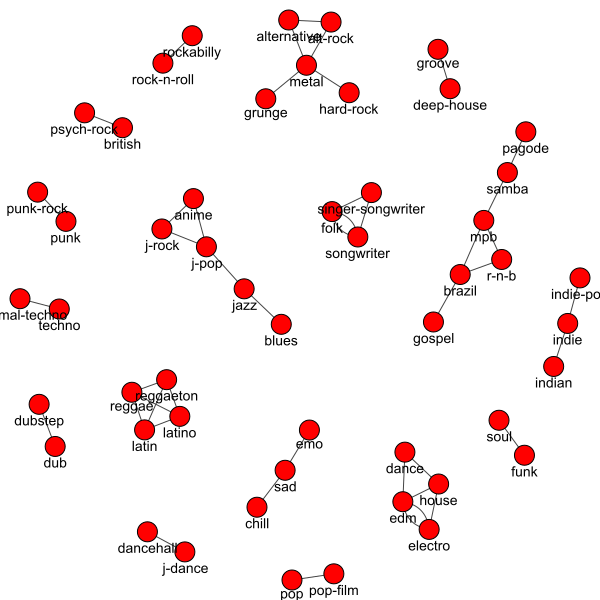

In [20]:
g = Graph.TupleList(edges, directed=False) # a non-directed graph is thus formed
g.vs['label'] = g.vs['name']
g.vs["label_dist"] = 1
layout = g.layout("fr")

plot(g, layout=layout)

### Genre relations

The resulting iGraph proves to be very useful in determining how certain genres are related to each other. Some of these are indeed common sense, such as the relationships between grunge, hard-rock, metal and alt-rock etc as well as the connections between punk and punk-rock; while others prove to be informative - such as the relationship between psych-rock ([a style of rock music that materialized in the late 1960s](https://www.masterclass.com/articles/psychedelic-rock-explained)) and British music - a connection that is made clearer when researching on groups [such as the Beatles and the Rolling Stones](https://library.fiveable.me/history-music-1850-present/unit-11/british-invasion-psychedelic-rock/study-guide/Cktbh0MElpAxXTn1). 

By no means is the graph above perfect - as connections are also formed between nodes such as anime music and j-pop alongside genres like jazz and the blues; yet this can be improved with further tweaking and analysis. Nonetheless, some insights could also be granted from these queer pairings, given how cultural influences can blend spatially and temporally separated phenomena extremely close together - just like [anime and jazz music](https://www.cbr.com/cowboy-bebop-anime-jazz-soundtracks/). A further issue with the above visualisation, of course, is that it is admittedly rather bland and un-interactive, an issue that will be looked into in the following segments to come.

In [21]:
related_genres = []
for c in g.components():
    related_genres.append(sorted([g.vs[i]["label"] for i in c]))

In [22]:
list(map(lambda x:related_genres.remove(x),(['indian', 'indie', 'indie-pop'],['folk', 'singer-songwriter', 'songwriter'],
   ['anime', 'blues', 'j-pop', 'j-rock', 'jazz'])))
list(map(lambda x:related_genres.append(x),(['indie-pop', 'indie'],['singer-songwriter', 'songwriter'],
    ['blues','jazz'],['anime','j-pop','j-rock'])))
related_genres # the related genres displayed in the graph above can also be related (and tweaked) more closely together in code
# to be used in simplifying the genres in the dataframe below

[['punk', 'punk-rock'],
 ['alt-rock', 'alternative', 'grunge', 'hard-rock', 'metal'],
 ['minimal-techno', 'techno'],
 ['brazil', 'gospel', 'mpb', 'pagode', 'r-n-b', 'samba'],
 ['latin', 'latino', 'reggae', 'reggaeton'],
 ['dance', 'edm', 'electro', 'house'],
 ['deep-house', 'groove'],
 ['funk', 'soul'],
 ['dancehall', 'j-dance'],
 ['pop', 'pop-film'],
 ['chill', 'emo', 'sad'],
 ['british', 'psych-rock'],
 ['rock-n-roll', 'rockabilly'],
 ['dub', 'dubstep'],
 ['indie-pop', 'indie'],
 ['singer-songwriter', 'songwriter'],
 ['blues', 'jazz'],
 ['anime', 'j-pop', 'j-rock']]

In [23]:
shared_genres = list(map(lambda x:sorted(x,key=len),related_genres))

lis = []
[lis.extend(i) for i in shared_genres]
len(lis) - len(shared_genres) 
# this reflects the number of genres that can be removed from the dataframe owing to their similarity with other pre-established ones

31

In [24]:
genre_mappings = {}
for genre in shared_genres:
    for g in genre:
        genre_mappings[g] = genre[0]

In [25]:
df["new_genres"] = df["track_genre"].apply(lambda x:genre_mappings.get(x,x)) 
# these new genres are then placed in another column in the dataframe as shown below
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,duration,new_genres
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,00:03:50.666000,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,00:02:29.610000,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,00:03:30.826000,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,00:03:21.933000,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,00:03:18.853000,acoustic


### Artistic Connections

Apart from looking at related genres for songs themselves - it can also be useful to analyse the relationships between artists of specific genres and observe how some artists may engage in multiple genres that are diverse from one another - further highlighting the talents of said artists and the range of music as a whole

In [26]:
df["indiv_artists"] = df["artists"].apply(lambda x:(x.split(";")))

In [27]:
artist_songs = {}

for i,r in df.iterrows():
    for n in r["indiv_artists"]:
        if n in artist_songs:
            artist_songs[n].add(r["new_genres"])
        else:
            artist_songs[n] = {r["new_genres"]}

In [28]:
artist_songs

{'Gen Hoshino': {'acoustic', 'anime', 'songwriter'},
 'Ben Woodward': {'acoustic', 'emo'},
 'Ingrid Michaelson': {'acoustic', 'kids'},
 'ZAYN': {'acoustic', 'edm', 'pop'},
 'Kina Grannis': {'acoustic', 'folk', 'piano'},
 'Chord Overstreet': {'acoustic'},
 'Tyrone Wells': {'acoustic', 'indie'},
 'A Great Big World': {'acoustic', 'piano'},
 'Christina Aguilera': {'acoustic', 'latin', 'piano', 'rock'},
 'Jason Mraz': {'acoustic', 'indie', 'kids', 'rock'},
 'Colbie Caillat': {'acoustic'},
 'Ross Copperman': {'acoustic', 'piano'},
 'Zack Tabudlo': {'acoustic'},
 'Dan Berk': {'acoustic', 'emo'},
 'Anna Hamilton': {'acoustic', 'emo'},
 'Deepend': {'acoustic', 'french', 'groove', 'songwriter'},
 'Landon Pigg': {'acoustic'},
 'Andrew Foy': {'acoustic', 'guitar'},
 'Renee Foy': {'acoustic', 'guitar'},
 'Boyce Avenue': {'acoustic'},
 'Bea Miller': {'acoustic', 'edm', 'indie', 'metal'},
 'Jennel Garcia': {'acoustic'},
 'Brandi Carlile': {'acoustic', 'folk'},
 'Sam Smith': {'acoustic', 'edm', 'folk

In [29]:
df[df["artists"].str.contains("Gen Hoshino")] 
# it seems like the very same track 'Comedy' by Gen Hoshino can be titled under the genres 'acoustic','anime' and 'songwriter'
# this is somewhat understandable, yet also problematic for our visualisation. To counter this, duplicate genres for the same song
# will be dropped for the ease of crafting a cohesive network

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,duration,new_genres,indiv_artists
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,1,...,0.03220,0.000001,0.3580,0.715,87.917,4,acoustic,00:03:50.666000,acoustic,[Gen Hoshino]
406,4nmjL1mUKOAfAbo9QG9tSE,Gen Hoshino,POP VIRUS,Koi,53,251266,False,0.598,0.819,9,...,0.00081,0.000000,0.2180,0.878,158.115,4,acoustic,00:04:11.266000,acoustic,[Gen Hoshino]
663,12qmPGMrOCogibc7qyxT9s,Gen Hoshino,I Wanna Be Your Ghost (feat. Ghosts),I Wanna Be Your Ghost (feat. Ghosts),50,225533,False,0.829,0.751,11,...,0.01420,0.014000,0.0414,0.960,129.993,4,acoustic,00:03:45.533000,acoustic,[Gen Hoshino]
751,3dPpQeLTWjCjEbSevDMQfW,Gen Hoshino,FUSHIGI,FUSHIGI,49,290000,False,0.753,0.574,3,...,0.05120,0.000004,0.1410,0.527,89.024,4,acoustic,00:04:50,acoustic,[Gen Hoshino]
756,2pcuXnZhTirLXsfXGVFTv2,Gen Hoshino,Doraemon,Doraemon,41,239933,False,0.640,0.547,4,...,0.00676,0.000049,0.0585,0.950,159.992,4,acoustic,00:03:59.933000,acoustic,[Gen Hoshino]
800,7rIBp3U5Igzn44l7Z7mOtE,Gen Hoshino,YELLOW DANCER,SUN,48,241466,False,0.782,0.684,1,...,0.02100,0.000000,0.1250,0.858,108.171,4,acoustic,00:04:01.466000,acoustic,[Gen Hoshino]
850,6hDBkm6B8HF9B4oATW28YN,Gen Hoshino,POP VIRUS,Pop Virus,47,182000,False,0.629,0.441,9,...,0.03390,0.000000,0.2340,0.782,78.177,4,acoustic,00:03:02,acoustic,[Gen Hoshino]
62102,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,1,...,0.03220,0.000001,0.3580,0.715,87.917,4,j-pop,00:03:50.666000,anime,[Gen Hoshino]
99152,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,1,...,0.03220,0.000001,0.3580,0.715,87.917,4,singer-songwriter,00:03:50.666000,songwriter,[Gen Hoshino]
102151,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,1,...,0.03220,0.000001,0.3580,0.715,87.917,4,songwriter,00:03:50.666000,songwriter,[Gen Hoshino]


In [30]:
artist_songs = {}

uf = df.drop_duplicates("track_id")
for i,r in uf.iterrows():
    for n in r["indiv_artists"]:
        if n in artist_songs:
            artist_songs[n].add(r["new_genres"])
        else:
            artist_songs[n] = {r["new_genres"]}

In [31]:
genre_connections = list(artist_songs.values())
genre_connections = list(filter(lambda x:len(x)>1,genre_connections)) # connections between 2 or more genres are utilised
genre_connections = list(map(lambda x:sorted(x),genre_connections))

In [32]:
pairwise_connections = list(map(lambda x:list(itertools.combinations(x, 2)), genre_connections)) # and pairwise connections between multiple 
# genres are formed using the itertools library
genre_pairs = list(list(zip(*pairwise_connections))[0])
genre_pairs = [tuple(sorted(pair)) for pair in genre_pairs]

In [33]:
pair_counts = Counter(genre_pairs) # a Counter of these pairs is created for edge weightage purposes - pairs with greater counts
# are given stronger connections through the display of thicker edges

In [34]:
genres = list(set([genre for pair in genre_pairs for genre in pair]))
genre_index = {genre: idx for idx, genre in enumerate(genres)}

edges = [(genre_index[pair[0]], genre_index[pair[1]]) for pair in pair_counts.keys()]
weights = list(pair_counts.values())

In [35]:
g = Graph(edges=edges)
g.es['weight'] = weights
g.vs['label'] = genres

In [36]:
pyvis_net = Network(notebook=True) # Pyvis is used for the creation of a dynamic, interactive html graph - built atop of the one 
# that has been formed from iGraph

cmap= mpl.cm.tab20 
# matplotlib's colour map is used for randomly choosing colours for our Graph - allowing for a bright visualisation to be created
colors = [cmap(random.random()) for _ in range(len(genres))]

for vertex in g.vs:
    choice = random.choice(colors)
    colour = f'rgb({int(choice[0] * 255)}, {int(choice[1] * 255)}, {int(choice[2] * 255)})'
    pyvis_net.add_node(vertex.index,label = "" ,title=vertex["label"], size = 20, color = colour)

for edge in g.es:
    source, target = edge.tuple
    pyvis_net.add_edge(source, target, weight = edge['weight'], width = int((np.log(edge['weight'])+0.1)*2))
    # the width of the edge is determined logarithmically using the formula above - note that it incorporates the 
    # edge weight that has been formed above

In [37]:
pyvis_net.force_atlas_2based(gravity=-500, central_gravity=0.01, spring_length=200, spring_strength=0.1, damping=0.5)
pyvis_net.repulsion()

In [38]:
pyvis_net.show("genre_connections.html") # the graph is saved into the html file 'genre_connections'
# Note that loading the html file may take a few seconds

genre_connections.html


### Artists' Relations

As opposed to the simple and static iGraph created previously, the network crafted using pyVis is much more appealing and insightful. The colouring of various nodes and edges helps one to identify particular nodes of interest much more clearly - as well as facilitate the recognition of stronger connections (via thicker edges). The ability to have words only be displayed when a node is hovered over also helps to prevent the graph from being too cluttered - though admittedly given the number of nodes and connections from the above relationship is quite large for such a display (indeed making it also take a while to load). Further approaches can be taken to rectify this issue - as we will see above - but it is undeniable that the ability to zoom into such a visualisation and actually physically interact with it does garner much more interest than a bargraph/ scatterplot would.

In [39]:
pop_artists = {}

uf = df.drop_duplicates("track_id")
for i,r in uf.iterrows():
    for n in r["indiv_artists"]:
        if n in pop_artists:
            pop_artists[n][0].append(r["popularity"])
            pop_artists[n][1].add(r["new_genres"])
        else:
            pop_artists[n] = ([r["popularity"]],{r["new_genres"]})

### Top Artists

Instead of looking into the musical relationships across all artists and genres - it may be prudent to analyse those relationships of top performing artists (and the pairings between genres) in a Graph-Based visualisation. The comparatively smaller number of data points can help to make the network simpler to look into, while also being informative for a data-analyst.

In [40]:
artist_popularity = list(map(lambda x:(np.percentile(pop_artists[x][0],25),np.percentile(pop_artists[x][0],50),
    np.percentile(pop_artists[x][0],75),len(pop_artists[x][0])),pop_artists)) 
# the popularity of an artist is garnered by analysing the quartiles of their song ratings

In [41]:
top_artists = {}
for i, k in enumerate(pop_artists):
    top_artists[k] = [artist_popularity[i][0],artist_popularity[i][1],artist_popularity[i][2],artist_popularity[i][3],pop_artists[k][1]]

In [42]:
af = pd.DataFrame(top_artists).transpose()
af.columns=["Lower_Q","Mid_Q","Upper_Q","Count","Genres"]

In [43]:
af["Lower_measure"] = af["Lower_Q"]*af["Count"] # a multiplication of an artist's 25th percentile rating is taken together with the number 
# of songs that artist has - since top performing artists are likely to have a lot of songs and a relatively high 25th percentile
af["Median_measure"] = af["Mid_Q"]*af["Count"] # a similar approach is taken for their median rating

In [44]:
af.head()

,Lower_Q,Mid_Q,Upper_Q,Count,Genres,Lower_measure,Median_measure
Gen Hoshino,47.5,49.0,51.5,7,{acoustic},332.5,343.0
Ben Woodward,38.0,40.0,46.0,9,{acoustic},342.0,360.0
Ingrid Michaelson,45.75,54.0,56.25,12,"{kids, acoustic}",549.0,648.0
ZAYN,58.0,68.0,78.0,9,"{pop, acoustic, edm}",522.0,612.0
Kina Grannis,48.0,52.0,58.0,21,"{acoustic, folk}",1008.0,1092.0


In [45]:
sf = af.sort_values("Lower_measure",ascending=False)
sf.head(20) # It appears that both measures yield fairly similar results

,Lower_Q,Mid_Q,Upper_Q,Count,Genres,Lower_measure,Median_measure
Pritam,47.0,53.0,60.0,323,"{indian, folk, pop, hip-hop, edm}",15181.0,17119.0
Arijit Singh,54.0,60.0,64.0,259,"{songwriter, indian, folk, pop, hip-hop, k-pop...",13986.0,15540.0
BTS,63.0,67.0,71.0,165,"{k-pop, pop, edm, indie}",10395.0,11055.0
The Beatles,55.25,58.5,64.75,150,{british},8287.5,8775.0
Yuvan Shankar Raja,45.0,50.0,56.0,167,"{k-pop, pop, hip-hop, indian}",7515.0,8350.0
Linkin Park,43.25,50.0,58.75,154,"{hardcore, metal}",6660.5,7700.0
Hillsong Worship,40.0,44.0,48.0,166,{world-music},6640.0,7304.0
Arctic Monkeys,53.0,59.5,67.0,110,"{garage, indie}",5830.0,6545.0
Glee Cast,34.25,44.0,48.0,170,{club},5822.5,7480.0
Anirudh Ravichander,58.0,61.0,67.25,96,"{indian, pop, hip-hop, k-pop, indie}",5568.0,5856.0


In [46]:
abv_avg_genre = sf[sf["Mid_Q"]>=50]

In [47]:
top_genres = list(abv_avg_genre["Genres"].values)
top_genres = list(map(sorted,top_genres))

In [48]:
pairwise_connections = list(map(lambda x:list(itertools.combinations(x, 2)), top_genres))
top_pairs = list(list(zip(*list(filter(lambda x:x!=[],pairwise_connections))))[0])
top_pairs = [tuple(sorted(pair)) for pair in top_pairs]

In [49]:
top_counts = Counter(top_pairs) 
# once again, a counter is used to logarithmically thicken edge weights in accordance to the strength of relationships between genres

In [50]:
ind_counts = Counter([pair[0] for pair in top_pairs])
# a similar approach is currently also taken for the genres themselves - with genres with more artists under them being larger
# than those with fewer artists

In [51]:
top_genres = list(set([genre for pair in top_pairs for genre in pair]))
top_index = {genre: idx for idx, genre in enumerate(top_genres)}

edges = [(top_index[pair[0]], top_index[pair[1]]) for pair in top_counts.keys()]
weights = list(top_counts.values())

In [52]:
g = Graph(edges=edges)
g.es['weight'] = weights
g.vs['label'] = genres

In [53]:
artist_net = Network(notebook=True)

for vertex in g.vs:
    size = int(np.log((ind_counts[vertex['label']])+10)*5+1) # the size of a node is thus now dynamic as well
    choice = random.choice(colors)
    colour = f'rgb({int(choice[0] * 255)}, {int(choice[1] * 255)}, {int(choice[2] * 255)})'
    artist_net.add_node(vertex.index,label = "" ,title=vertex["label"], size = size, color = colour)

for edge in g.es:
    source, target = edge.tuple
    artist_net.add_edge(source, target, weight = edge['weight'], width = int((np.log(edge['weight'])+0.1)*2))

In [54]:
artist_net.force_atlas_2based(gravity=-500, central_gravity=0.01, spring_length=200, spring_strength=0.1, damping=0.5)
artist_net.repulsion()

In [55]:
artist_net.show("top_connections.html") # the relationships between genres of top performing artists is then saved in the following file

top_connections.html


## Conclusion

While Graph-Based Visualisations may be slightly overpowering for those who are new to it; we can see how such graphs can be very powerful in conveying information between multiple data points - not just through the network itself but also the capability for these visualisations to be interactive and thus engaging on our part. By playing around with such visualisations, we also gain gain new perspectives on the underlying relationships within our data, uncovering patterns or connections that may not be immediately obvious in a tabular or relational format.

Moreover, these visualizations encourage us to think about data in a graphical and relational way, shifting from a purely linear or structured viewpoint to one that emphasizes interconnections and hierarchies. This change in mindset is critical when dealing with datasets that are inherently non-linear, as it [allows for better understanding of clusters, pathways, and dependencies](https://www.nebula-graph.io/posts/why-use-graph-databases). Ultimately, graph-based visualizations not only help us [to explore and analyse data in innovative ways but also invite us to rethink the way we approach complex, interconnected information](https://cambridge-intelligence.com/graph-visualization-use-cases/#:~:text=It's%20insightful%20%E2%80%93%20an%20interactive%20graph,data%2C%20or%20a%20static%20visualization.&text=Graph%20visualization%20has%20become%20a,a%20growing%20number%20of%20domains.).